<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/CVA_malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons
!pip install -q tensorflow-probability

# to generate gifs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 16.0 MB/s 


In [ ]:
from IPython import display
from IPython.display import clear_output
import os
from zipfile import ZipFile
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras import layers

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

AUTOTUNE = tf.data.AUTOTUNE
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.8.2


load the malaria dataset

In [ ]:
if not os.path.exists('malaria.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/malaria.zip ./malaria.zip

with ZipFile('malaria.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-08-18 22:05:55--  https://storage.googleapis.com/pet-detect-239118/malaria.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63432592 (60M) [application/x-zip-compressed]
Saving to: ‘malaria.zip’

malaria.zip         100%[===================>]  60.49M  84.8MB/s    in 0.7s    

2022-08-18 22:05:56 (84.8 MB/s) - ‘malaria.zip’ saved [63432592/63432592]

--2022-08-18 22:05:56--  http://./malaria.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-18 22:05:56--
Total wall clock time: 1.3s
Downloaded: 1 files, 60M in 0.7s (84.8 MB/s)


In [ ]:
data_dir = './malaria'
data_dir = pathlib.Path(data_dir)
blood_imgs = list(data_dir.glob('*/*.png'))

print(f'There are {len(blood_imgs)} in total.')

There are 24820 in total.


In [ ]:
file_list = list(data_dir.glob('*/*.png'))
positive_paths = []
negative_paths = []
for file in file_list:
  file = str(file)
  parts = tf.strings.split(file, os.path.sep)
  if parts[-2] == 'Parasitemic':
    positive_paths.append('/content/'+file)
  else:
    negative_paths.append('/content/'+file)

total = len(positive_paths)
test_idx = np.random.choice(total, 4000, replace=False)
print(f'Total image: {total*2}')


Total image: 24820


In [ ]:
positive_paths = np.array(positive_paths)
negative_paths = np.array(negative_paths)
test_positive = np.take(positive_paths, test_idx, axis=0)
train_positive = np.delete(positive_paths, test_idx, axis=0)
test_negative = np.take(negative_paths, test_idx, axis=0)
train_negative = np.delete(negative_paths, test_idx, axis=0)

train_images = np.concatenate((train_positive, train_negative), axis=0)
test_images = np.concatenate((test_positive, test_negative), axis=0)
print(train_images.shape)
print(test_images.shape)

(16820,)
(8000,)


In [ ]:
if not os.path.exists('train'):
  os.mkdir('train')

if not os.path.exists('test'):
  os.mkdir('test')

os.mkdir('train/Parasitemic')
os.mkdir('test/Parasitemic')
os.mkdir('train/Uninfected')
os.mkdir('test/Uninfected')

In [ ]:
import shutil

for file in train_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/train'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

for file in test_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/test'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

In [ ]:
# Run this to reset the VAE run
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32, 32])


def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  if parts[-2] == 'Parasitemic':
    return tf.constant(1.0, dtype="float32")
  else:
    return tf.constant(0.0, dtype="float32")

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  # rescale from (0,255) to (0,1)
  img = (img / 127.5) - 1
  # img = img / 255.0
  return img, label


def CVA_process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  # rescale from (0,255) to (0,1)
  # img = (img / 127.5) - 1
  img = img / 255.0
  return img, label

Set up the datasets

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 2000

train_dataset = tf.data.Dataset.list_files("/content/train/*/*.png")
train_dataset = train_dataset.map(CVA_process_path, num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files("/content/test/*/*.png")
test_dataset = test_dataset.map(CVA_process_path, num_parallel_calls=tf.data.AUTOTUNE)
# test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# VAE cost function as negative ELBO (Evidence Lower Bound Objective)

def normal_log_pdf(sample, mean, sd, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  logvar = np.log((np.square(sd)))
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def vae_cost(x_true, model, analytic_kl=True, kl_weight=0.02):
  z_sample, mu, sd = model.encode(x_true)
  x_recons_logits = model.decoder(z_sample)
  # compute cross entropy loss for each dimension of every datapoint
  raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits) # bs*128*128*3
  # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,), the first term of the objective
  neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3]) # the first term of the objective

  # compute reverse KL divergence, either analytically or through MC approximation with one sample, the second term of the objective
  if analytic_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd), axis=1)  # shape=(batch_size, )
  else:
    logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
    logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
    kl_divergence = logqz_x - logpz
  elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
  return -elbo

In [ ]:
# Adjust the KL divergence weight here
@tf.function
def train_step(x_true, model, optimizer, analytic_kl=True, kl_weight=0.02):
  with tf.GradientTape() as tape:
    cost_mini_batch = vae_cost(x_true, model, analytic_kl, kl_weight)
  gradients = tape.gradient(cost_mini_batch, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return cost_mini_batch

In [ ]:
class Encoder_Z(tfk.layers.Layer):

    def __init__(self, dim_z, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        self.dim_x = (32, 32, 3)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=4, strides=(2, 2), padding='same')) # 16*16*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=64, kernel_size=4, strides=(2, 2), padding='same')) # 8*8*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=128, kernel_size=4, strides=(2, 2), padding='same')) # 4*4*128
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Flatten())
        layers.append(tfkl.Dense(self.dim_z * 2,
                                 activation=None))  # *2 because number of parameters for both mean and (raw) standard deviation
        return tfk.Sequential(layers)

In [ ]:
class Decoder_X(tfk.layers.Layer):

    def __init__(self, dim_z, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=(self.dim_z,))]
        layers.append(tfkl.Dense(4 * 4 * 16, activation=None))
        layers.append(tfkl.Reshape((4, 4, 16)))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same')) # 8*8*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')) # 16*16*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')) # 32*32*128
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=3, kernel_size=4, strides=1, padding='same'))

        return tfk.Sequential(layers)

In [ ]:
class VAE(tfk.Model):

    def __init__(self, dim_z, learning_rate, seed=2000, name="autoencoder", **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.dim_x = (32, 32, 3)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.seed = seed
        self.encoder = Encoder_Z(dim_z=self.dim_z).build()
        self.decoder = Decoder_X(dim_z=self.dim_z).build()

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.dim_z))
      return self.decode(eps, apply_sigmoid=True)


    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1 + tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

In [ ]:
autoencoder = VAE(128, 2e-4)
optimizer = tf.keras.optimizers.Adam(2e-4)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  z, mean, logvar = model.encode(test_sample)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    plt.subplot(4, 4, i + 1)
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.imshow(show_img)
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
images, labels = next(iter(test_dataset))
images.shape

TensorShape([256, 32, 32, 3])

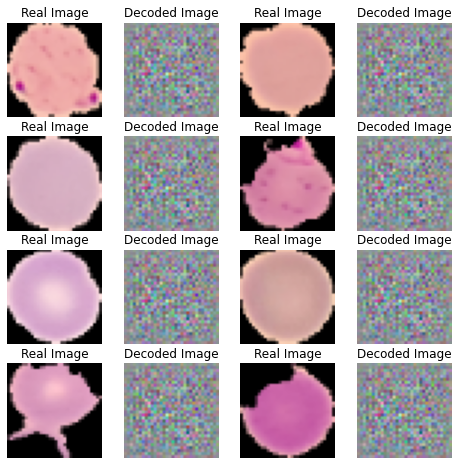

In [ ]:
z, mean, logvar = autoencoder.encode(images)
predictions = autoencoder.sample(z)
fig = plt.figure(figsize=(8, 8))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  if i % 2 == 0:
    show_img = tf.keras.preprocessing.image.array_to_img(images[i, :, :, :])
    plt.title('Real Image')
    plt.imshow(show_img)
    plt.axis('off')
  else:
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.title('Decoded Image')
    plt.imshow(show_img)
    plt.axis(False)

Train the CVA

In [ ]:
epochs = 200
images, labels = next(iter(test_dataset))
test_sample = images

Epoch: 200, Test set ELBO: -40.15034484863281, time elapse for current epoch: 5.189970016479492


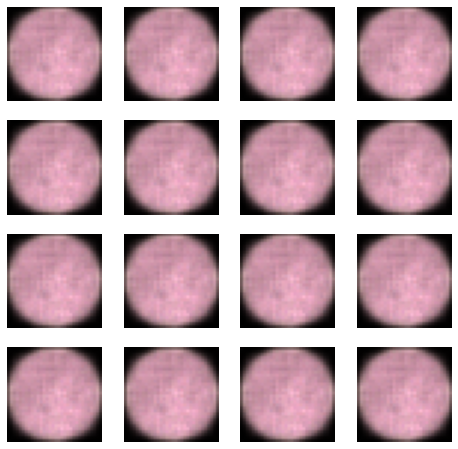

In [ ]:
generate_and_save_images(autoencoder, 0, test_sample)
vae_history = dict()
vae_history['loss'] = []
vae_history['val_loss'] = []

for epoch in range(1, epochs + 1):

  start_time = time.time()
  loss = []
  for train_x, _ in train_dataset:
    temp_loss = train_step(train_x, autoencoder, optimizer)
    loss.append(temp_loss)   

  loss = np.array(loss)
  end_time = time.time()
  elbo = np.mean(loss)
  vae_history['loss'].append(elbo)
  print(f'epoch -- {epoch}: Loss: {elbo}')

  val_loss = tf.keras.metrics.Mean()
  for test_x, _ in test_dataset:
    val_loss(vae_cost(test_x, autoencoder))
  val_elbo = -val_loss.result()
  vae_history['val_loss'].append(val_elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, val_elbo, end_time - start_time))
  generate_and_save_images(autoencoder, epoch, test_sample)

save the trained encoder and decoder

In [ ]:
autoencoder.encoder.save('CVA_encoder_32')
autoencoder.decoder.save('CVA_decoder_32')
!zip -r CVA_decoder_32.zip CVA_decoder_32
!zip -r CVA_encoder_32.zip CVA_encoder_32

  adding: CVA_decoder_32/ (stored 0%)
  adding: CVA_decoder_32/keras_metadata.pb (deflated 92%)
  adding: CVA_decoder_32/saved_model.pb (deflated 90%)
  adding: CVA_decoder_32/assets/ (stored 0%)
  adding: CVA_decoder_32/variables/ (stored 0%)
  adding: CVA_decoder_32/variables/variables.index (deflated 54%)
  adding: CVA_decoder_32/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CVA_encoder_32/ (stored 0%)
  adding: CVA_encoder_32/keras_metadata.pb (deflated 91%)
  adding: CVA_encoder_32/saved_model.pb (deflated 88%)
  adding: CVA_encoder_32/assets/ (stored 0%)
  adding: CVA_encoder_32/variables/ (stored 0%)
  adding: CVA_encoder_32/variables/variables.index (deflated 50%)
  adding: CVA_encoder_32/variables/variables.data-00000-of-00001 (deflated 8%)


Text(0.5, 0, 'epoch')

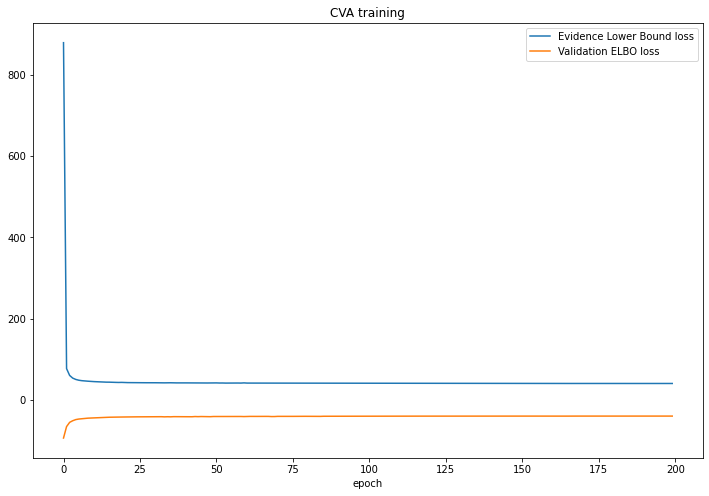

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(vae_history['loss'], label='Evidence Lower Bound loss')
plt.plot(vae_history['val_loss'], label='Validation ELBO loss')
plt.legend(loc='best')
plt.title('CVA training')
plt.xlabel('epoch')

Train the 2nd CVA with more diversity

In [ ]:
def vae_cost(x_true, model, analytic_kl=True, kl_weight=0.01):
  z_sample, mu, sd = model.encode(x_true)
  x_recons_logits = model.decoder(z_sample)
  # compute cross entropy loss for each dimension of every datapoint
  raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits) # bs*128*128*3
  # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,), the first term of the objective
  neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3]) # the first term of the objective

  # compute reverse KL divergence, either analytically or through MC approximation with one sample, the second term of the objective
  if analytic_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd), axis=1)  # shape=(batch_size, )
  else:
    logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
    logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
    kl_divergence = logqz_x - logpz
  elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
  return -elbo

# Adjust the KL divergence weight here
@tf.function
def train_step(x_true, model, optimizer, analytic_kl=True, kl_weight=0.01):
  with tf.GradientTape() as tape:
    cost_mini_batch = vae_cost(x_true, model, analytic_kl, kl_weight)
  gradients = tape.gradient(cost_mini_batch, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return cost_mini_batch


autoencoder2 = VAE(128, 2e-4)

Epoch: 200, Test set ELBO: -39.9485969543457, time elapse for current epoch: 5.170743942260742


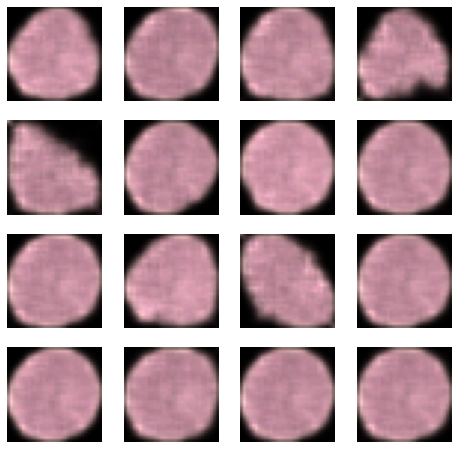

In [ ]:
generate_and_save_images(autoencoder2, 0, test_sample)
vae_history = dict()
vae_history['loss'] = []
vae_history['val_loss'] = []

for epoch in range(1, epochs + 1):

  start_time = time.time()
  loss = []
  for train_x, _ in train_dataset:
    temp_loss = train_step(train_x, autoencoder2, optimizer)
    loss.append(temp_loss)   

  loss = np.array(loss)
  end_time = time.time()
  elbo = np.mean(loss)
  vae_history['loss'].append(elbo)
  print(f'epoch -- {epoch}: Loss: {elbo}')

  val_loss = tf.keras.metrics.Mean()
  for test_x, _ in test_dataset:
    val_loss(vae_cost(test_x, autoencoder2))
  val_elbo = -val_loss.result()
  vae_history['val_loss'].append(val_elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, val_elbo, end_time - start_time))
  generate_and_save_images(autoencoder2, epoch, test_sample)

By setting lower KL weight and trained with more epochs, the generated images have more diversity

In [ ]:
autoencoder.encoder.save('CVA_encoder2_32')
autoencoder.decoder.save('CVA_decoder2_32')
!zip -r CVA_decoder2_32.zip CVA_decoder2_32
!zip -r CVA_encoder2_32.zip CVA_encoder2_32

  adding: CVA_decoder2_32/ (stored 0%)
  adding: CVA_decoder2_32/keras_metadata.pb (deflated 92%)
  adding: CVA_decoder2_32/saved_model.pb (deflated 90%)
  adding: CVA_decoder2_32/assets/ (stored 0%)
  adding: CVA_decoder2_32/variables/ (stored 0%)
  adding: CVA_decoder2_32/variables/variables.index (deflated 54%)
  adding: CVA_decoder2_32/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CVA_encoder2_32/ (stored 0%)
  adding: CVA_encoder2_32/keras_metadata.pb (deflated 91%)
  adding: CVA_encoder2_32/saved_model.pb (deflated 89%)
  adding: CVA_encoder2_32/assets/ (stored 0%)
  adding: CVA_encoder2_32/variables/ (stored 0%)
  adding: CVA_encoder2_32/variables/variables.index (deflated 50%)
  adding: CVA_encoder2_32/variables/variables.data-00000-of-00001 (deflated 8%)
